Going to run the GNB model in order to get a good baseline for performace
1. Control vs. All Park
1. PD vs. MSA/PSP
1. MSA vs. PD/PSP
1. PDP vs. PD/MSA

## Imports and Function Definitions

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)

In [5]:
# parameters and ranges to plot
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10)
#     "fss__k" : range(1,115,3)
}

clf = Pipeline([
#     ('Norm', Normalizer()),
    #("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#         ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced'))
])

## 1. Control vs. PD/MSA/PSP

In [7]:
# Get the data
data1 = pd.read_excel('training_data.xlsx')
data1 = group_classes(data1, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=0.35, random_state=42)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=20, scoring='f1_micro')

# Tuning hyper-parameters for f1_micro

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   14.2s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.86      0.97      0.91        95
          1       0.99      0.93      0.96       227

avg / total       0.95      0.94      0.95       322




             precision    recall  f1-score   support

          0       0.86      0.97      0.91        95
          1       0.99      0.93      0.96       227

avg / total       0.95      0.94      0.95       322



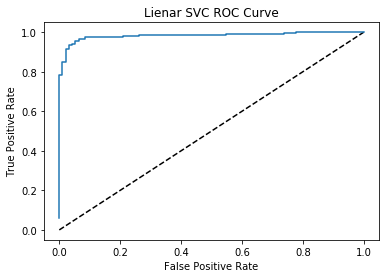

In [16]:
from sklearn.metrics import roc_curve
model = Pipeline([
    ('Scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', probability=True, C=0.088586679041008323, class_weight='balanced'))
])
model.fit(X_train1, Y_train1)

y_true, y_pred = Y_test1, model.predict(X_test1)
print(classification_report(y_true, y_pred))

y_pred_prob = model.predict_proba(X_test1)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test1, y_pred_prob)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label='Linear SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lienar SVC ROC Curve')
plt.show()

## 2. PD vs MSA/PSP

In [17]:
# Get the data
data2 = pd.read_excel('training_data.xlsx')
data2 = group_classes(data2, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=0.35, random_state=42)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=5, scoring='f1_micro')

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.95      0.89      0.92       164
          1       0.77      0.89      0.83        66

avg / total       0.90      0.89      0.89       230




[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


             precision    recall  f1-score   support

          0       0.95      0.89      0.92       164
          1       0.77      0.89      0.83        66

avg / total       0.90      0.89      0.89       230



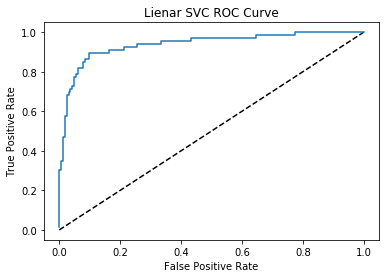

In [18]:
from sklearn.metrics import roc_curve
model = Pipeline([
    ('Scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', probability=True, C=0.01438449888287663, class_weight='balanced'))
])
model.fit(X_train2, Y_train2)

y_true, y_pred = Y_test2, model.predict(X_test2)
print(classification_report(y_true, y_pred))

y_pred_prob = model.predict_proba(X_test2)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test2, y_pred_prob)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label='Linear SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lienar SVC ROC Curve')
plt.show()

## 3. MSA vs PD/PSP

In [19]:
# Get the data
data3 = pd.read_excel('training_data.xlsx')
data3 = group_classes(data3, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=0.35, random_state=42)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=5, scoring='f1_micro')

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    8.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished


Best parameters set found on development set:

{'classifier__C': 0.0023357214690901212}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.98      0.91      0.94       208
          1       0.49      0.82      0.61        22

avg / total       0.93      0.90      0.91       230




             precision    recall  f1-score   support

          0       0.98      0.91      0.94       208
          1       0.49      0.82      0.61        22

avg / total       0.93      0.90      0.91       230



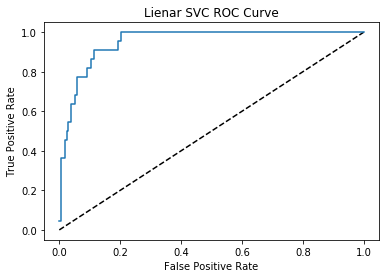

In [20]:
from sklearn.metrics import roc_curve
model = Pipeline([
    ('Scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', probability=True, C=0.0023357214690901212, class_weight='balanced'))
])
model.fit(X_train3, Y_train3)

y_true, y_pred = Y_test3, model.predict(X_test3)
print(classification_report(y_true, y_pred))

y_pred_prob = model.predict_proba(X_test3)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test3, y_pred_prob)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label='Linear SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lienar SVC ROC Curve')
plt.show()

## 4. PSP vs PD/MSA

In [21]:
# Get the data
data4 = pd.read_excel('training_data.xlsx')
data4 = group_classes(data4, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=0.35, random_state=42)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=5, scoring='f1_micro')

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.98      0.90      0.94       186
          1       0.69      0.91      0.78        44

avg / total       0.92      0.90      0.91       230




[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


             precision    recall  f1-score   support

          0       0.98      0.90      0.94       186
          1       0.69      0.91      0.78        44

avg / total       0.92      0.90      0.91       230



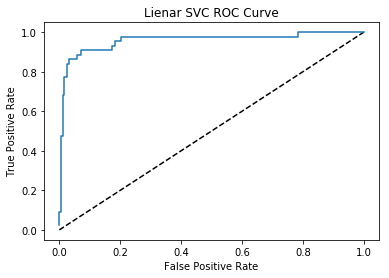

In [22]:
from sklearn.metrics import roc_curve
model = Pipeline([
    ('Scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', probability=True, C=0.01438449888287663, class_weight='balanced'))
])
model.fit(X_train4, Y_train4)

y_true, y_pred = Y_test4, model.predict(X_test4)
print(classification_report(y_true, y_pred))

y_pred_prob = model.predict_proba(X_test4)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test4, y_pred_prob)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label='Linear SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lienar SVC ROC Curve')
plt.show()